In [1]:
import cv2
import cv2 as cv
import numpy as np
import ffmpeg
import torch
import matplotlib.pyplot as plt

from eve import EVE
from datetime import datetime
from config import DefaultConfig

from preprocess import get_frames_and_timestamps, preprocess_frames
from utils import get_sample_input

config = DefaultConfig()

In [20]:
screen_frame, screen_timestamps = get_frames_and_timestamps('./videos/scene.mp4')

Parsing frames...
.......................................................................................................................................................................................................
Done!


In [95]:
eyes_frame, timestamps = get_frames_and_timestamps('./videos/eyes.mp4')

Parsing frames...
.......................................................................................................................................................................................................
Done!


In [102]:
left_eye_patch = eyes_frame[:, :, :128]

In [106]:
right_eye_patch = eyes_frame[:, :, 128:]

In [2]:
inp = get_sample_input()

In [ ]:
eve = EVE().eval()

In [108]:
%%time
out_ok = eve(inp, create_images=True)
out_ok_ = eve(inp, create_images=True)
torch.equal(out_ok['PoG_px_final'], out_ok_['PoG_px_final'])

CPU times: user 1min 17s, sys: 13.1 s, total: 1min 30s
Wall time: 14 s


True

In [109]:
required_params = [
    'left_o',
    'left_o_validity',
    'right_o',
    'right_o_validity',
    
    'camera_transformation', 
    'inv_camera_transformation', 
    
    'left_R', 
    'left_R_validity',
    
    'right_R',
    'right_R_validity',
    
    'left_h', 
    'left_h_validity',
    
    'right_h',
    'right_h_validity',
    
    'head_R',
    
    'millimeters_per_pixel',
    'pixels_per_millimeter',
    
    'left_eye_patch',
    'right_eye_patch',
    'timestamps',
    
    'screen_timestamps', 
    'screen_frame'
]    

In [110]:
pixels_per_millimeter = [3.4720, 3.4727]
millimeters_per_pixel = [0.2880, 0.2880]

In [237]:
inp.keys()

dict_keys(['camera_matrix', 'camera_transformation', 'face_R', 'face_R_validity', 'face_W', 'face_W_validity', 'face_h', 'face_h_validity', 'face_o', 'face_o_validity', 'facial_landmarks', 'facial_landmarks_validity', 'head_rvec', 'head_rvec_validity', 'head_tvec', 'head_tvec_validity', 'inv_camera_transformation', 'left_R', 'left_R_validity', 'left_W', 'left_W_validity', 'left_h', 'left_h_validity', 'left_o', 'left_o_validity', 'millimeters_per_pixel', 'pixels_per_millimeter', 'right_R', 'right_R_validity', 'right_W', 'right_W_validity', 'right_h', 'right_h_validity', 'right_o', 'right_o_validity', 'head_R', 'timestamps', 'left_eye_patch', 'right_eye_patch', 'screen_timestamps', 'screen_frame', 'participant', 'subfolder', 'camera'])

In [240]:
trimmed_inp = inp.copy()

# those params have no influence on the error
del trimmed_inp['face_R']
del trimmed_inp['face_R_validity']
del trimmed_inp['face_W']
del trimmed_inp['face_W_validity']
del trimmed_inp['face_h']
del trimmed_inp['face_h_validity']
del trimmed_inp['face_o']
del trimmed_inp['face_o_validity']
del trimmed_inp['camera_matrix']
del trimmed_inp['facial_landmarks']
del trimmed_inp['facial_landmarks_validity']
del trimmed_inp['head_rvec']
del trimmed_inp['head_rvec_validity']
del trimmed_inp['head_tvec']
del trimmed_inp['head_tvec_validity']
del trimmed_inp['participant']
del trimmed_inp['subfolder']
del trimmed_inp['camera']
try:
    del trimmed_inp['o']
    del trimmed_inp['o_validity']
except:
    pass
del trimmed_inp['left_W']
del trimmed_inp['left_W_validity']
del trimmed_inp['right_W']
del trimmed_inp['right_W_validity']

In [245]:
x, n, h, w = trimmed_inp['camera_transformation'].shape

In [244]:
torch.Tensor(camera_transformation_mean).shape

torch.Size([4, 4])

In [255]:
trimmed_inp['camera_transformation'] = torch.Tensor([camera_transformation_mean for i in range(n)]).unsqueeze(0)

In [256]:
trimmed_inp['camera_transformation'].shape

torch.Size([1, 30, 4, 4])

In [257]:
# those two below are crucial, they make or break the inference
shape = inp['camera_transformation'].shape
# trimmed_inp['camera_transformation'] = torch.zeros(shape)
trimmed_inp['inv_camera_transformation'] = torch.zeros(shape)

In [263]:
inp = next(iter(dataloader))

In [258]:
out_meh = eve(trimmed_inp, create_images=True)

pog_ok = out_ok['PoG_px_final'].type(torch.int32)
pog_meh = out_meh['PoG_px_final'].type(torch.int32)

err = (abs(pog_ok - pog_meh) / pog_meh).mean()
err = err.type(torch.float).mean().detach().numpy()

print(f'Error: {err: %}')
[k for k in trimmed_inp.keys() if k not in required_params]

Error:  886.468697%


['o', 'o_validity']

^ o and o_validity are not required but they are put back onto input automatically post-inference

In [5]:
out.keys()

dict_keys(['left_pupil_size', 'right_pupil_size', 'left_g_initial', 'PoG_px_initial', 'g_final', 'PoG_px_final', 'timestamps', 'o', 'left_R', 'head_R', 'g_initial', 'PoG_cm_initial', 'millimeters_per_pixel', 'pixels_per_millimeter', 'camera_transformation', 'inv_camera_transformation', 'PoG_cm_final', 'full_loss', 'both_eye_patch', 'screen_frame', 'initial_heatmap', 'final_heatmap', 'refined_gaze_history'])

In [7]:
inp['camera_matrix'][0][0]

tensor([[1.7806e+03, 0.0000e+00, 9.5933e+02],
        [0.0000e+00, 1.7799e+03, 5.7931e+02],
        [0.0000e+00, 0.0000e+00, 1.0000e+00]])

In [2]:
from datetime import datetime

unix = 9.258039978340000000e+14

unix *= 1e-9

datetime.fromtimestamp(unix)

datetime.datetime(1970, 1, 11, 18, 10, 3, 997834)

In [ ]:
from utils import list_keys
list_keys(inp)

In [ ]:
inp['millimeters_per_pixel'][0][0]  # the same

inp['face_o'][0][:3]  # those each are different

inp['head_tvec_validity'][0]  # the same

inp['head_R'][0][0]  # each of those is the same

inp['camera_matrix'][0][0]  # those are also the same

inp['camera_transformation'][0][0]  # those are also the same

In [127]:
one = frame.numpy().squeeze().transpose(0, 3, 2, 1)[0]

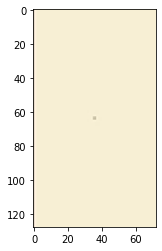

In [130]:
plt.imshow(one.astype(int))

In [ ]:
one.shape

(128, 72, 3)

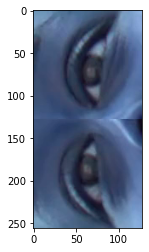

In [41]:
plt.imshow(all_eyes.squeeze().transpose(0, 2, 1, 3)[0])

numpize all the outputs

In [9]:
inputs = {
    k: v.numpy() if isinstance(v, torch.Tensor) else v
    for k, v in inp.items()
}

In [10]:
outputs = {
    k: v.detach().numpy() if isinstance(v, torch.Tensor) else v
    for k, v in out.items()
}

In [ ]:
# Visualize
we_have_gt = 'left_g_gt' in outputs
all_g_init = outputs['left_g_initial']
if config.load_full_frame_for_visualization:
    all_eyes = outputs['both_eye_patch']
    all_eyes = (all_eyes + 1.0) * (255.0 / 2.0)
    all_eyes = all_eyes.astype(np.uint8)
    all_eyes = np.transpose(all_eyes, [0, 1, 3, 4, 2])[:, :, :, :, ::-1]
    if 'screen_full_frame' in inputs:
        all_screen = inputs['screen_full_frame']
        all_screen = all_screen.astype(np.uint8)
        all_screen = all_screen[:, :, :, :, ::-1]  # RGB to BGR
all_PoG_init = outputs['PoG_px_initial']
if config.load_screen_content:
    all_g_final = outputs['g_final']
    all_PoG_final = outputs['PoG_px_final']
if we_have_gt:
    all_g_gt = outputs['left_g_gt']
    all_PoG_gt = outputs['PoG_px_gt']
    all_PoG_gt_validity = outputs['PoG_px_gt_validity']
num_entries = all_g_init.shape[0]
sequence_len = all_g_init.shape[1]
for index in range(num_entries):
    if config.load_full_frame_for_visualization:
        eyes = all_eyes[index, :]
        if 'screen_full_frame' in inputs:
            screen = all_screen[index, :]
    g_init = all_g_init[index, :]
    PoG_init = all_PoG_init[index, :]
    if config.load_screen_content:
        g_final = all_g_final[index, :]
        PoG_final = all_PoG_final[index, :]
    if we_have_gt:
        g_gt = all_g_gt[index, :]
        PoG_gt = all_PoG_gt[index, :]
        gt_validity = all_PoG_gt_validity[index, :]
    final_out_frames = {
        'screen_yrg': [screen[t, :] for t in range(sequence_len)],
    }

    for suffix, frames in final_out_frames.items():
        frames = [np.copy(frame.transpose(2, 1, 0)) for frame in frames]        
        # Choose whether to mirror frame
        _g_init = np.copy(g_init)
        _PoG_init = np.copy(PoG_init)
        if config.load_screen_content:
            _g_final = np.copy(g_final)
            _PoG_final = np.copy(PoG_final)
        if we_have_gt:
            _g_gt = np.copy(g_gt)
            _PoG_gt = np.copy(PoG_gt)
            _gt_validity = np.copy(gt_validity)
        if suffix.startswith('mirrored_'):
            frames = [np.ascontiguousarray(np.fliplr(frame)) for frame in frames]
            if config.load_screen_content:
                _PoG_final[:, 0] = 1920.0 - _PoG_final[:, 0]
                _g_final[:, 1] = -_g_final[:, 1]
            _PoG_init[:, 0] = 1920.0 - _PoG_init[:, 0]
            _g_init[:, 1] = -_g_init[:, 1]
            if we_have_gt:
                _PoG_gt[:, 0] = 1920.0 - _PoG_gt[:, 0]
                _g_gt[:, 1] = -_g_gt[:, 1]
        _all_valid = np.ones((sequence_len, ), dtype=np.bool)

        if 'screen' in suffix:
            # Choose what to draw
            to_draw = []
            last_bit = suffix.split('_')[-1]
            is_drawing_gt = 'r' in last_bit
            for char in list(last_bit):
                if char == 'y':
                    to_draw.append(('Initial Estimate', _PoG_init, _all_valid,
                                   [0, 180, 180]))
                elif char == 'g':
                    to_draw.append(('After Refinement (Ours)', _PoG_final, _all_valid,
                                   [0, 180, 0]))
                elif char == 'r':
                    if we_have_gt:
                        to_draw.append(('Tobii Data (Groundtruth)', _PoG_gt, _gt_validity,
                                       [0, 0, 180]))
                else:
                    raise ValueError('Invalid thing to draw: %s' % char)

            if we_have_gt and is_drawing_gt:
                # Draw error/residual "labels"
                for label, PoG_list, validity, colour in to_draw:
                    for t, (x, y) in enumerate(PoG_list):
                        if 'Groundtruth' not in label and _gt_validity[t] == 1:
                            x_gt, y_gt = _PoG_gt[t, :]
                            cv.line(frames[t], (x, y), (x_gt, y_gt), color=[0, 0, 0],
                                    thickness=5, lineType=cv.LINE_AA)
                            cv.line(frames[t], (x, y), (x_gt, y_gt), color=colour,
                                    thickness=2, lineType=cv.LINE_AA)

            # Draw fixation circles
            for _, PoG_list, validity, colour in to_draw:
                for t, (x, y) in enumerate(PoG_list):
                    if validity[t] == 1:
                        print(frames[t].shape)
                        dat_frame = frames[t]
                        cv.circle(frames[t], (x, y), radius=14, color=[0, 0, 0],
                                  thickness=-1, lineType=cv.LINE_AA)
                        cv.circle(frames[t], (x, y), radius=10, color=colour,
                                  thickness=-1, lineType=cv.LINE_AA)

            # Now label with a "legend"
            for t in range(sequence_len):
                offset_dy = 0
                for label, _, _, colour in to_draw:
                    offset_x = 50
                    offset_y = 90 + offset_dy
                    cv.putText(frames[t], label, org=(offset_x, offset_y),
                               fontFace=cv.FONT_HERSHEY_DUPLEX, fontScale=1.6,
                               color=[0, 0, 0], thickness=9, lineType=cv.LINE_AA)
                    cv.putText(frames[t], label, org=(offset_x, offset_y),
                               fontFace=cv.FONT_HERSHEY_DUPLEX, fontScale=1.6,
                               color=colour, thickness=2, lineType=cv.LINE_AA)
                    offset_dy += 80

In [129]:
outputs['final_heatmap'].shape

(1, 1, 72, 128)

In [131]:
outputs['final_heatmap']

array([[[[7.9507887e-04, 2.3905448e-05, 2.0349207e-05, ...,
          1.4132869e-05, 2.4584566e-05, 8.6931727e-04],
         [3.9339735e-05, 2.8538850e-07, 2.0966429e-07, ...,
          1.7660605e-07, 3.6887170e-07, 5.8417867e-05],
         [3.1582586e-05, 1.7856398e-07, 1.1397826e-07, ...,
          1.0160696e-07, 2.1219887e-07, 4.2072923e-05],
         ...,
         [1.6961612e-05, 7.9440227e-08, 5.0405696e-08, ...,
          6.5933925e-08, 7.5935674e-08, 2.2999006e-05],
         [1.1452198e-05, 5.7859012e-08, 3.1774167e-08, ...,
          2.6920956e-08, 3.4043609e-08, 1.2881868e-05],
         [7.7666261e-04, 2.4954403e-05, 1.6399055e-05, ...,
          1.1738554e-05, 1.4117460e-05, 7.0119876e-04]]]], dtype=float32)

In [130]:
outputs['PoG_px_final'].shape

(1, 30, 2)

In [33]:
to_draw

[('Initial Estimate',
  array([[ 870.16675,  631.401  ],
         [ 871.5189 ,  608.01697],
         [ 870.97327,  607.51025],
         [ 855.6344 ,  596.30444],
         [ 849.87695,  599.1553 ],
         [ 849.2261 ,  600.0177 ],
         [ 862.6631 ,  601.4745 ],
         [ 853.6671 ,  585.3136 ],
         [ 864.1959 ,  587.0206 ],
         [ 863.0836 ,  592.3374 ],
         [ 843.61176,  602.53564],
         [ 842.04956,  598.11145],
         [ 850.74146,  583.5012 ],
         [ 541.22974,  388.25775],
         [ 530.88806,  384.9935 ],
         [ 526.69226,  364.0498 ],
         [ 536.75824,  365.47562],
         [ 530.53955,  368.3319 ],
         [ 537.01587,  355.8333 ],
         [ 897.8745 ,  432.55194],
         [1006.2014 ,  465.36322],
         [1002.97565,  482.5559 ],
         [1068.5787 ,  437.00616],
         [1066.5491 ,  415.06946],
         [1068.3577 ,  408.83124],
         [1077.3525 ,  397.80463],
         [1299.0645 ,  445.93097],
         [1312.8704 ,  439.54965]